## Imports and Setup

Run these in command prompt to install the libraries used
* pip install imagehash
* pip install torch torchvision
* pip install matplotlib
* pip install pillow
* pip install tqdm
* pip install opencv-python

Importing the Libraries that we are using

In [95]:
# Imports
import os

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

setting some constants

In [96]:
# Data

MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

## Preprocessing and creating dataset

Preprocessing the images to create the dataset of color and grayscale images pairs.
* Normalising the Image pixel value between 0 - 1
* Resizing Images
* splitting images to train and test

In [97]:
# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = './Landscape_Images_Dataset'
        self.images = os.listdir(f'{self.dataroot}')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/{img_path}') / 255
        # gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        gray_img = transforms.Grayscale()(color_img)

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

## Data Transformation

Apply transformations to your images (resizing) to prepare them for the model. Also splitting the image into train and test datasets. 80% of thhe data will be train and remaining will be test.

In [98]:
# resizing the images
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])
# Load the dataset
dataset = LandscapeDataset(transform=transform)

# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train and set data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

Just visualizing images randomly to see how we got the data

In [99]:
# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(4):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

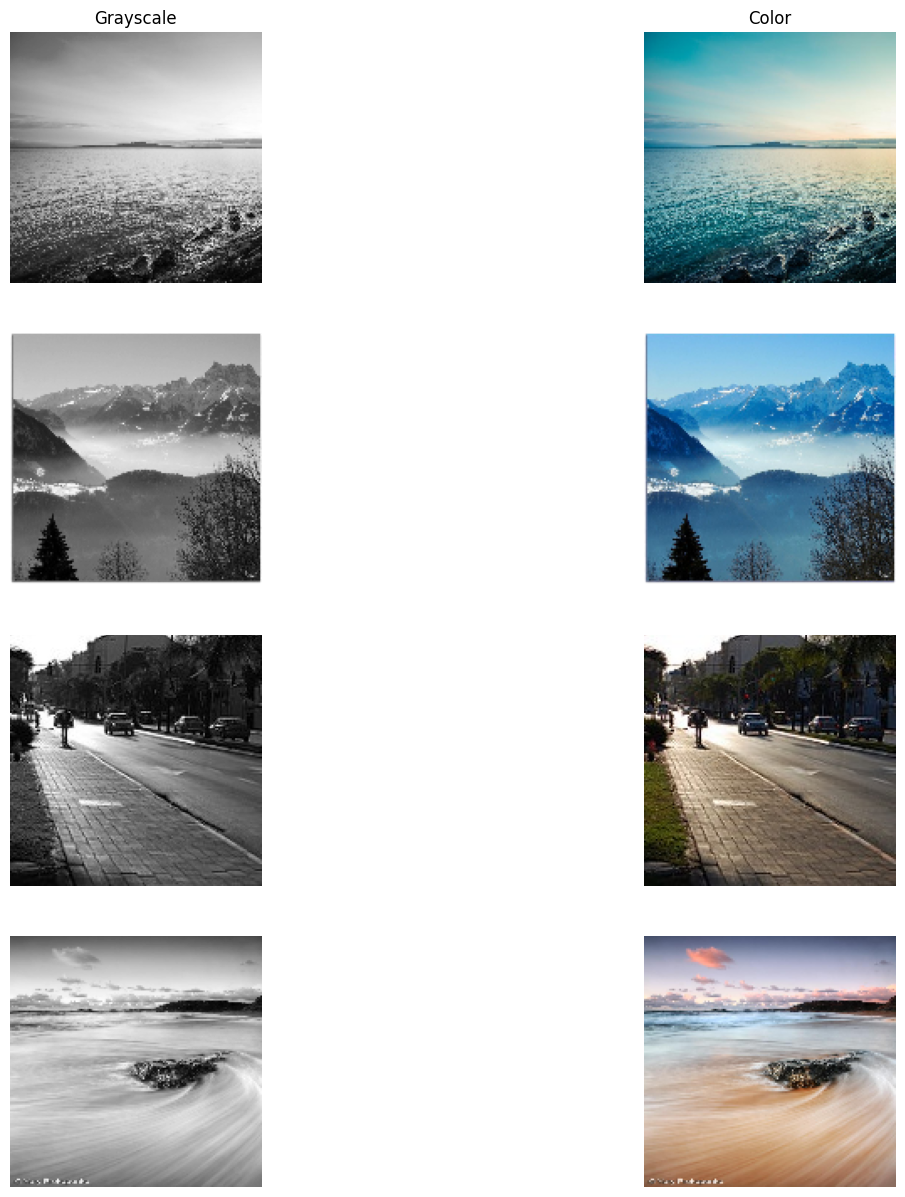

In [100]:
color, gray = next(iter(trainloader))
show_images(color, gray)

Initializing Training Constants

In [101]:
# Training Variables

EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model Architecture

Creating an Autoencoder Architecture. Has an Encoder and a Decoder in it.
* Encoder:
- Downsampling Images:
- The Encoder has special filters that look at the details of a picture. These filters start simple and become more complex. Think of it like zooming out from a detailed view to a bigger picture.
Each filter creates a new version of the picture with fewer details. So, it's like making the picture a bit blurry, but we keep the important parts.

* Decoder:
- Upsampling Images:
- Now, the Decoder takes these simplified pictures and tries to recreate the original detailed picture.
It uses special tools to add details back, making the picture sharper. It's like zooming back in but trying to recover the important details.

* Encoder has a down1 to down4 are convolutional layers with increasing numbers of output channels. They perform downsampling of the input image.
* Decoder has a up1 to up4 are transposed convolutional layers (also known as deconvolution or upsampling layers). They perform upsampling of the encoded representation.
* Also initialized the activation functions using to train the neural network. ReLU (Rectified Linear Unit) is used as the activation function after each convolutional and transposed convolutional layer, except for the last layer of the decoder, where Sigmoid is used.
* The forward method defines the forward pass of the network. It applies the convolutional and transposed convolutional layers, interleaved with activation functions, to encode and then decode the input.
* The final output u4 is the colorized image, and sigmoid is used to ensure that the pixel values are between 0 and 1.

In [102]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

Initializing the model and checking the number of parameters to trained.

In [103]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 3,470,659'

## Initialize Model, Loss, and Optimizer

Inializing the loss function and the optimizer using

* Loss Function: Think of the loss function as a score that tells the computer how much it needs to improve. A lower score means the computer is getting better at coloring the pictures.
* optimizer: If the loss function is the score, the optimizer is the coach that guides the computer to take small steps in the right direction. It's like a coach helping you improve your basketball skills by adjusting your technique.

In [104]:
# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training Loop

Now the training starts

* Practice Sessions (Epochs):
We're giving the model many practice sessions. In each session, it looks at pictures and tries to add colors.

* Breaking Practice into Steps (Batches):
Each practice session is divided into smaller steps. In each step, the model looks at a bunch of pictures.

* Looking at Pictures:
The model looks at both a grayscale picture (no colors) and a real colored picture.

* Trying to Colorize:
It tries to add colors to the grayscale picture using its current skills.

* Checking its Work (Loss):
Checks how different the model's colored picture is from the real one. This difference is called "loss."

* Getting Feedback (Optimization):
The optimizer tells the model how to adjust its coloring strategy to get closer to the real colors. This is the model's way of getting better.

* Many Rounds of Practice (Iterations):
The model repeats these steps many times, practicing and adjusting its approach to coloring.

* Getting Better Each Time:
After each round of practice, we check how much the model improved on average.

* Finally:
After all the practice sessions, we say, "Training Finished!" The model has learned how to color pictures better.

## Evaluation on Test Data

Evaluating the performance of your trained model on the testing data

In [105]:
train_loss_values = []
train_accuracy_values = []

# Define the training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    total_mse = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculate loss between coloured image and predicted image
        loss = criterion(color_img, predictions)

        # Calcuate gradients and back propagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate Mean Squared Error for accuracy
        mse = torch.nn.functional.mse_loss(color_img, predictions)
        total_mse += mse.item()

    # Calculate and print accuracy
    train_accuracy = 1 - (total_mse / len(trainloader.dataset))

    # Store values for plotting
    train_loss_values.append(running_loss / len(trainloader))
    train_accuracy_values.append(train_accuracy)
    
    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}, Accuracy: {train_accuracy:.6f}')

print('Training Finished!')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.091995, Accuracy: 0.996167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.086763, Accuracy: 0.996385


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.081405, Accuracy: 0.996608


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.079510, Accuracy: 0.996687


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.073164, Accuracy: 0.996952


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.070001, Accuracy: 0.997083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.065760, Accuracy: 0.997260


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.060660, Accuracy: 0.997472


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.056514, Accuracy: 0.997645


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.051672, Accuracy: 0.997847
Training Finished!


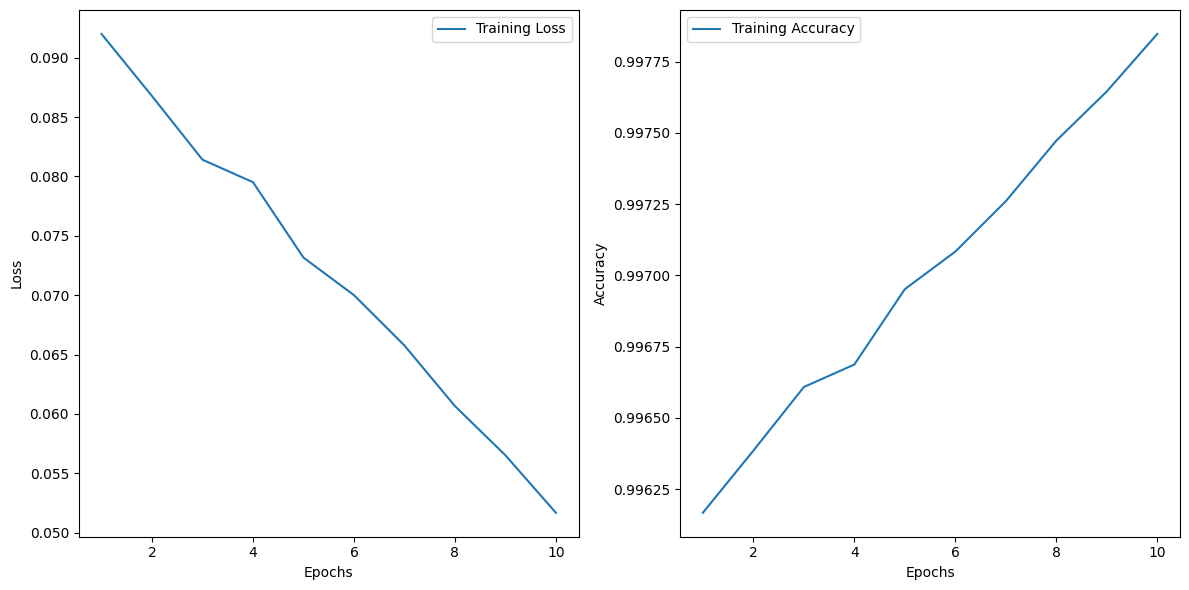

In [106]:
# Plot training results
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracy_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [107]:
# Test on testing data
total_loss = 0.0
total_mse = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

        mse = torch.nn.functional.mse_loss(color_img, prediction)
        total_mse += mse.item()

# Calculate and print accuracy
accuracy = 1 - (total_mse / len(testloader.dataset))
print(f'Total Testing Loss: {total_loss/len(testloader):.3f}, Accuracy: {accuracy:.6f}')

  0%|          | 0/1 [00:00<?, ?it/s]

Total Testing Loss: 0.039, Accuracy: 0.992236


In [108]:
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr

# Set the model to evaluation mode
model.eval()

# Initialize variables to accumulate metrics
total_mse = 0.0
total_psnr = 0.0

# Evaluate on the test set
with torch.no_grad():
    for idx, (color_img, gray_img) in enumerate(testloader):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        # Calculate Mean Squared Error
        mse = torch.nn.functional.mse_loss(color_img, predictions)
        total_mse += mse.item()

        # Calculate Peak Signal-to-Noise Ratio
        psnr_value = psnr(color_img.cpu().numpy(), predictions.cpu().numpy(), data_range=1.0)

        total_psnr += psnr_value

# Calculate average metrics
average_mse = total_mse / len(testloader)
average_psnr = total_psnr / len(testloader)

# Print and/or log the results
print(f'Average MSE: {average_mse:.6f}')
print(f'Average PSNR: {average_psnr:.6f}')


Average MSE: 0.038820
Average PSNR: 14.109451


## Visualization

Finally we are predicting the model with the images. Here, visualized the original, gray scale and the predicted output images using matplotlib

In [73]:
# Visualize some predictions
def show_predictions(gray, color, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()


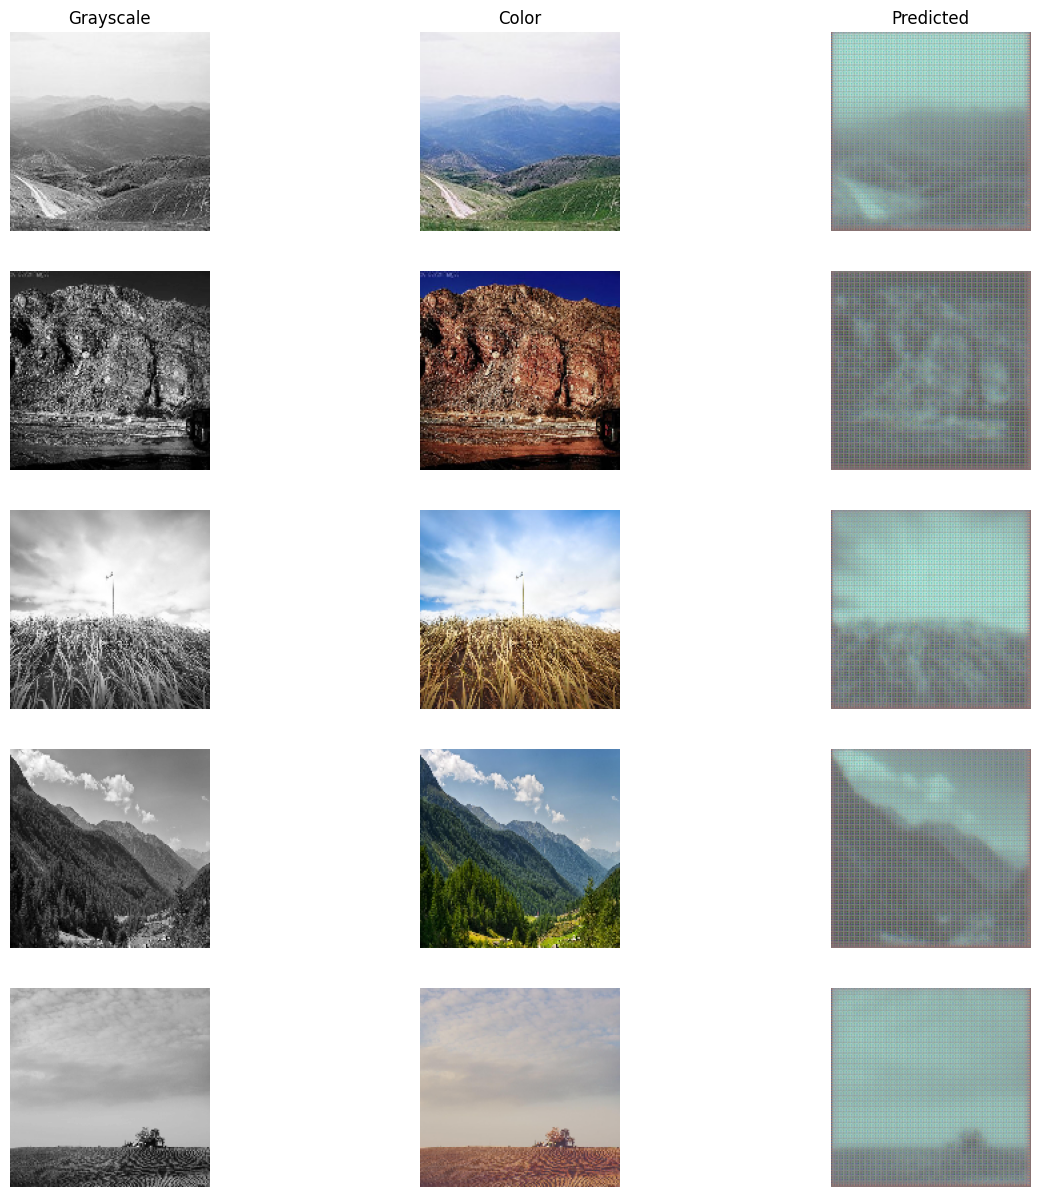

In [74]:
show_predictions(gray_img.detach().cpu(), color_img.detach().cpu(), prediction.detach().cpu())

## Predictions

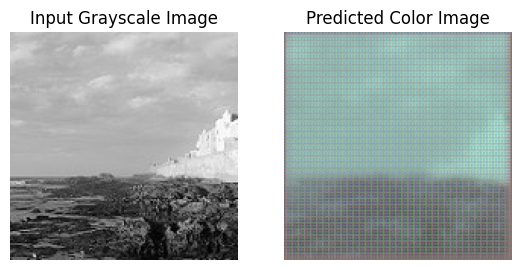

In [75]:
# Assuming 'model' is your trained autoencoder model

def predict_image(model, input_image_path):
    # Read and preprocess the new image
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])

    input_image = Image.open(input_image_path).convert('L')  # Convert to grayscale
    input_image = transform(input_image).unsqueeze(0)  # Add batch dimension

    # Move input image to the same device as the model
    device = next(model.parameters()).device
    input_image = input_image.to(device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        predicted_image = model(input_image)

    # Move the predicted image back to CPU for visualization
    predicted_image = predicted_image.cpu()

    return input_image.squeeze(0), predicted_image.squeeze(0)

# Example usage:
input_image_path = 'predict_img\img_3.jpg'
input_image, predicted_image = predict_image(model, input_image_path)

# Visualize the input grayscale image, original color image, and predicted color image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image.squeeze().numpy(), cmap='gray')
plt.title('Input Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_image.permute(1, 2, 0).numpy())
plt.title('Predicted Color Image')
plt.axis('off')

plt.show()

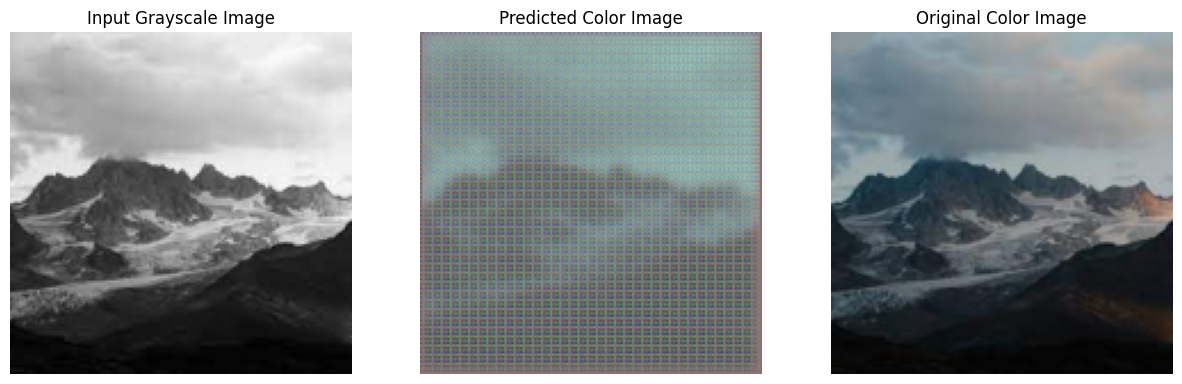

In [76]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'model' is your trained autoencoder model

def predict_and_visualize(model, input_gray_path, original_color_path):
    # Read and preprocess the new grayscale image
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])

    input_gray = Image.open(input_gray_path).convert('L')  # Convert to grayscale
    input_gray = transform(input_gray).unsqueeze(0)  # Add batch dimension
    input_gray = input_gray.to(next(model.parameters()).device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        predicted_color = model(input_gray)

    # Move the predicted color image back to CPU for visualization
    predicted_color = predicted_color.cpu()

    # Read and preprocess the original color image
    original_color = Image.open(original_color_path)
    original_color = transform(original_color).unsqueeze(0)  # Add batch dimension

    # Visualize the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_gray.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Input Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_color.squeeze().permute(1, 2, 0).numpy())
    plt.title('Predicted Color Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_color.squeeze().permute(1, 2, 0).numpy())
    plt.title('Original Color Image')
    plt.axis('off')

    plt.show()

# Example usage:
input_gray_path = 'predict_img\img_5.jpg'
original_color_path = 'predict_img\img_5_ori.jpg'
predict_and_visualize(model, input_gray_path, original_color_path)


## Saving the model

Saving the model for future uses. We can integrate it into various places.

In [59]:
# Save the model
# torch.save(model.state_dict(), 'your_model.pth')
